# Tutorial: Fraud detection with Graph Attention Networks
By Sing Kwan NG and Anthony TAING as part of the Stanford CS224W course project.
In this tutorial we will show you the fraud detection use case (for a node classification task) on Bitcoin dataset  by using the first version of GAT model and the GATv2 (Graph Attention Network model version2) .We will implement it by using our customs layers with PyG and the buitin PyG layers.

# Setup


In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import os

def unzip(location,**kwargs):
    import zipfile
    with zipfile.ZipFile(location,"r") as zip_ref:
        zip_ref.extractall(**kwargs)

def unzip_data(location):
    if not os.path.exists('data'):
        os.mkdir('data')
    unzip(location,path='data')

def is_colab():
    import sys
    return 'google.colab' in sys.modules

def init():

    import sys
    if is_colab():
        from google.colab import drive
        drive.mount('/content/drive')
        unzip('/content/drive/MyDrive/data science project/save_results.zip')
        drive_path = '/content/drive/MyDrive/data science project'
        unzip_data(drive_path + '/elliptic.zip')

        repo_name = 'deep-learning-note'
        if repo_name not in os.listdir():
            !git clone https://github.com/taimoon/deep-learning-note
        %pip install torch_geometric
        torch_cuda_arg = r'https://data.pyg.org/whl/torch-2.0.0+cu118.html'
        %pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f {torch_cuda_arg}

        sys.path.insert(0,'./deep-learning-note/model/fraud detection/')

    else:
        sys.path.insert(0,'./model/fraud detection/')


# %pip install torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

FOLDERNAME = "/content/" if is_colab() else "./"
init()
DATA_PATH = 'data/elliptic_bitcoin_dataset/'

## Load packages

In [3]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix,average_precision_score
from sklearn.model_selection import train_test_split

# About Dataset

## Description
The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

If you make use of the Elliptic Data Set in your research, please consider citing:

[1] Elliptic, www.elliptic.co.
[2] M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

## Content
This anonymized data set is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.

## Nodes and edges
The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.

## Features
There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks. **Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.**

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

## License
This data set is distributed under the Creative CommonsAttribution-NonCommercial-NoDerivatives License 4.0 International.

# Data ETL

We have hosted the dataset on Gdrive to the public for convenience for one click download. However, the original data is hosted on kaggle as well. If you want to download data from Kaggle using API(if you already have an account) or get it manually from: https://www.kaggle.com/ellipticco/elliptic-data-set.

In [4]:
Download=False
if Download:
    !gdown --id 1CIFpAquzYBA98gQCdMb92fC0w6yrYf2m
    !gdown --id 1Cfh0VIXWTc8EK96WRZdyaqgA2-JwvsUG
    !gdown --id 1Cfh8hA9Tl8uCPrLSmcIQI3qCbEjOFl7C
    DATA_PATH = FOLDERNAME

## Load data

In [6]:
# Load data from the folder
df_features = pd.read_csv(DATA_PATH+'elliptic_txs_features.csv',header=None)
df_edges = pd.read_csv(DATA_PATH+"elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv(DATA_PATH+"elliptic_txs_classes.csv")

In [7]:
contain_null = lambda df : df.isnull().any().any()
assert(not contain_null(df_features))
assert(not contain_null(df_edges))
assert(not contain_null(df_classes))

In [8]:
# reformat classes 0:licit, 1:illicit, 2:unknown
idx_to_class = ['Licit','Illicit','Unknown']
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

<BarContainer object of 3 artists>

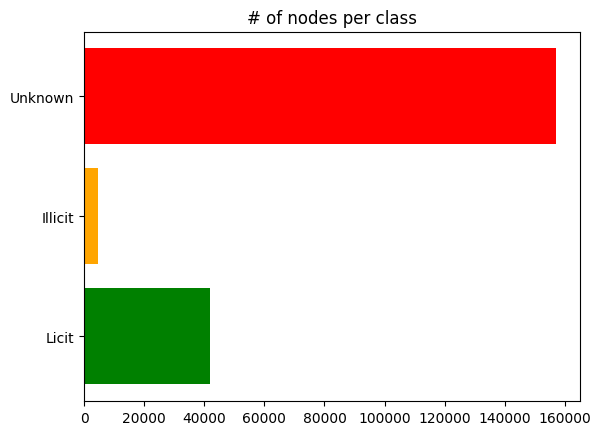

In [9]:
# See repartition of nodes per class
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh(idx_to_class, group_class['txId'].values, color=['g', 'orange', 'r'] )

## EDA - Preview of data features, edges and their labels

In [10]:
# View node features
# Data is each node is a transaction ID, and edges are a bit weird, but its like a "previous transaction" edge type
# column 0 = transaction id, column 1 = time step
# first 94 = info of transaction
# remaining 72 = aggregrated
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [11]:
# See edges
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [12]:
# See classes
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


## Merge dataset

In [13]:
tmp1 = pd.merge(df_edges,df_features[[0,1]],how='left',left_on='txId1',right_on=0)
tmp2 = pd.merge(df_edges,df_features[[0,1]],how='left',left_on='txId2',right_on=0)
res = tmp1[1] == tmp2[1]
res.all()

True

In [14]:
# Merge features with classes
df_merge = df_features.merge(df_classes, how='left', left_on=0, right_on="txId")
df_merge

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,2
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,2
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,2
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,173077460,2
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,158577750,2
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,158375402,1
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,158654197,2


In [15]:
df_merged_edges = df_edges.merge(df_features[[0,1]],how='left',left_on='txId1',right_on=0)
df_merged_edges.head()

,txId1,txId2,0,1
0,230425980,5530458,230425980,1
1,232022460,232438397,232022460,1
2,230460314,230459870,230460314,1
3,230333930,230595899,230333930,1
4,232013274,232029206,232013274,1


## Temporal Split

In [16]:
# Setup trans ID to node ID mapping
def temporal_split(t = 1):
    # ---- #
    NODE_ID_COL,TIMESTEP_COL = 0,1
    df = df_merge[df_merge[TIMESTEP_COL] == t]
    df = df.sort_values(0).reset_index(drop=True)

    nodes = df[NODE_ID_COL].values
    node_to_id = {j:i for i,j in enumerate(nodes)}

    edges = df_merged_edges[df_merged_edges[TIMESTEP_COL] == t]
    edges = edges.drop(columns=[NODE_ID_COL,TIMESTEP_COL])
    edges.txId1 = edges.txId1.map(node_to_id)
    edges.txId2 = edges.txId2.map(node_to_id)
    edge_index = torch.tensor(edges.values.astype(int)).T.long().contiguous() # create a tensor

    # set all edge weights to be 1
    weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.double)

    labels = df['class'].values

    # mapping txIds to corresponding indices, to pass node features to the model
    node_features = df.drop(['txId'], axis=1).copy()
    transID_to_nodeID = lambda: node_features[NODE_ID_COL].map(node_to_id)
    node_features[NODE_ID_COL] = transID_to_nodeID()

    # Retain known vs unknown ID
    classified_idx = node_features['class'][node_features['class']!=2].index
    unclassified_idx = node_features['class'][node_features['class']==2].index

    classified_illicit_idx = node_features['class'][node_features['class']==1].index
    classified_licit_idx = node_features['class'][node_features['class']==0].index

    node_features = node_features.drop(columns=[NODE_ID_COL, TIMESTEP_COL, 'class'])

    node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)


    from torch_geometric.data import Data
    from sklearn.model_selection import train_test_split
    train_idx, valid_idx = train_test_split(classified_idx.values, test_size=0.15, random_state=42)

    data = Data(x=node_features_t, edge_index=edge_index, edge_attr=weights,
                                y=torch.tensor(labels, dtype=torch.double),
                id_to_node = {j:i for i,j in node_to_id.items()},
                classified_idx = classified_idx,
                classified_illicit_idx = classified_illicit_idx,
                classified_licit_idx = classified_licit_idx,
                unclassified_idx = unclassified_idx,
                train_idx = train_idx,
                valid_idx = valid_idx,)
    # Add in the train and valid idx

    return data

In [17]:
def fn():
    # check whether temporal_split is correct
    for t in range(1,50):
        data = temporal_split(t)
        data.edge_index
        restored = [(data.id_to_node[a.item()],data.id_to_node[b.item()]) for a,b in data.edge_index.T]
        restored = np.array(restored)
        edges = df_merged_edges[df_merged_edges[1] == t]
        edges = edges.drop(columns=[0,1])

        # edges
        res = restored == edges.values
        assert(res.all() is np.bool_(True))

        df = df_features[df_features[1] == t].sort_values(0)[range(2,166+1)]
        res = torch.tensor(df.values) == data.x
        assert(res.all().item() is True)
# fn()

# Create a PyG dataset

Each PyG dataset stores a list of `torch_geometric.data.Data` objects, where each `torch_geometric.data.Data` object represents a graph. We can easily get the `Data` object by indexing into the dataset.

For more information such as what is stored in the `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

We convert data to PyGeometric graph data format by using node_features, edge_index, weights and labels initialized before.

In [18]:
train_data = [temporal_split(t) for t in range(1,34+1)]
test_data = [temporal_split(t) for t in range(35,49+1)]

# Model setup


In [19]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor

from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import pickle

train_data = [data.to(device) for data in train_data]
test_data = [data.to(device) for data in test_data]

## Prebuilt with PyG's built-in  layers
In this section, we are using PyG's built-in layers with 2 layers and an additional MLP layers for the GATs models.

### GCNConv

In [20]:
class GCN(nn.Module):
    def __init__(self,seed=42):
        super(GCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = pyg_nn.GCNConv(165,128)
        self.conv2 = pyg_nn.GCNConv(128,2)
        self.classifier = Linear(2, 1)

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.tanh(h)
        h = self.conv2(h, edge_index)
        embeddings = F.tanh(h)  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(embeddings)

        # return out, embeddings
        return F.sigmoid(out)

### GATConv


In [21]:
class GAT(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args,seed=42):
        self.args = args
        super(GAT, self).__init__()
        torch.manual_seed(seed)
        # use our gat message passing
        self.conv1 = pyg_nn.GATConv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = pyg_nn.GATConv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])

        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim),
            nn.Dropout(args['dropout'] ),
            nn.Linear(hidden_dim, output_dim),)

    def forward(self, data, adj=None):
        args = self.args
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

### GATv2Conv

In [22]:
class GATv2(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args,seed=42):
        self.args = args
        super(GATv2, self).__init__()
        torch.manual_seed(seed)
        #use our gat message passing
        self.conv1 = pyg_nn.GATv2Conv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = pyg_nn.GATv2Conv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])

        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim),
            nn.Dropout(args['dropout'] ),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, data, adj=None):
        args = self.args
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

### VGAE

In [23]:
class GCN_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,seed=42):
        super(GCN_Encoder, self).__init__()
        torch.manual_seed(seed)
        self.gcn_shared = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.gcn_mu = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = pyg_nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

class GAT_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,head=1,seed=42):
        super(GAT_Encoder, self).__init__()
        torch.manual_seed(seed)
        self.preprocess = nn.Sequential(
            nn.Linear(in_channels,2*in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(2*in_channels),
            nn.Linear(2*in_channels,in_channels),
            nn.ReLU(),
            nn.BatchNorm1d(in_channels),
            )
        self.gcn_shared = pyg_nn.GATv2Conv(in_channels, hidden_channels,head=head)
        self.gcn_mu = pyg_nn.GATv2Conv(hidden_channels, out_channels,head=head)
        self.gcn_logvar = pyg_nn.GATv2Conv(hidden_channels, out_channels,head=head)


    def forward(self, x, edge_index):
        x = self.preprocess(x)
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

class Node_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim,seed=42):
        super(Node_Decoder, self).__init__()
        torch.manual_seed(seed)
        self.fc_encoder = nn.Sequential(
            nn.Linear(output_dim,output_dim//4),
            nn.ReLU(),
            nn.BatchNorm1d(output_dim//4),
            nn.Linear(output_dim//4,latent_dim),
            nn.ReLU(),
        )
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim + latent_dim,hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim,output_dim),
            nn.Sigmoid(),
        )

    def forward(self,z,x):
        x = self.fc_encoder(x)
        x = torch.cat((x,z),dim=1)
        x = self.fc_decoder(x)
        return x


## Metric manager
We can use mutiple metrics, but we are interested on auroc, f1micro score.

Actually 2 types of f1 score can be used:

- 'micro' - Calculate metrics globally by counting the total true positives, false negatives and false positives.

- 'macro' -  Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [24]:
class metric_manager(object):
    def __init__(self, modes=("train", "val")):

        self.output = {}

        for mode in modes:
            self.output[mode] = {}
            metrics = ["loss","accuracy","f1micro","f1macro","aucroc","precision","recall","cm"]
            for m in metrics:
                self.output[mode][m] = []

    def store_metrics(self, mode, pred_scores, target_labels, loss, threshold=0.5):
        # calculate metrics
        pred_labels = pred_scores > threshold
        self.output[mode]['loss'].append(loss)
        # key
        kw = {
           "accuracy"   :  accuracy_score(target_labels, pred_labels),
            "f1micro"   :  f1_score(target_labels, pred_labels,average='micro'),
            "f1macro"   :  f1_score(target_labels, pred_labels,average='macro'),
            "aucroc"   : roc_auc_score(target_labels, pred_scores),
            "recall"    : recall_score(target_labels, pred_labels),
            "precision" : precision_score(target_labels, pred_labels),
            "cm"        : confusion_matrix(target_labels, pred_labels),
        }
        for m,v in kw.items():
            self.output[mode][m].append(v)

        return tuple(kw.values())

    # Get best results
    def get_best(self, metric, mode="val"):

        # Get best results index
        best_results = {}
        i = np.array(self.output[mode][metric]).argmax()

        # Output
        for m in self.output[mode].keys():
            best_results[m] = self.output[mode][m][i]

        return best_results

# Autoencoder Training

In [41]:
@torch.no_grad()
def test_gae(gae_model,node_model,data):
    gae_model.eval()
    z = gae_model.encode(data.x, data.edge_index)
    neg_edge_label = pyg_utils.negative_sampling(data.edge_index,data.x.shape[0])
    auc,ap = gae_model.test(z, data.edge_index, neg_edge_label)

    x = node_model(z,data.x)
    loss = F.mse_loss(x,data.x)
    loss = loss + gae_model.recon_loss(z, data.edge_index, neg_edge_label)
    loss = loss + (1 / data.num_nodes) * gae_model.kl_loss()
    return loss.item(),auc,ap

# Training loop
def update_gae(gae_model,node_model,data,optimizer):
    gae_model.train()
    z = gae_model.encode(data.x, data.edge_index)

    x = node_model(z,data.x)
    loss = F.mse_loss(x,data.x)

    loss = loss + gae_model.recon_loss(z, data.edge_index)
    loss = loss + (1 / data.num_nodes) * gae_model.kl_loss()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train_gae(gae_model,node_model,optimizer,hist,n):
    mean = lambda t: torch.tensor(t).mean().item()
    for epoch in range(n):
        loss_hist = []
        for data in train_data:
            loss = update_gae(gae_model,node_model,data,optimizer)
            loss_hist.append(loss)

        hist['train']['loss'].append(mean(loss_hist))
        loss_hist = []
        auc_hist = []
        ap_hist = []
        for data in test_data:
            loss,auc,ap = test_gae(gae_model,node_model,data)
            loss_hist.append(loss)
            auc_hist.append(auc)
            ap_hist.append(ap)
        hist['test']['loss'].append(mean(loss_hist))
        hist['test']['auc'].append(mean(auc_hist))
        hist['test']['ap'].append(mean(ap_hist))
        if (epoch+1) % 10 == 0 :
            clear_output()
            print(f"average precision {ap:.4f}")
            plot_loss(hist)

def init_hist():
    hist = {'train':{},'test':{}}
    metrics = "loss auc ap node_loss"
    for mode in "train test".split():
        for m in metrics.split():
            hist[mode][m]=[]
    return hist

def plot_loss(hist):
    fig,axs = plt.subplots(1,3,figsize=(12,4))
    epoch = len(hist['train']['loss'])
    fig.suptitle(f'GAE Training History Epoch - {epoch}')
    for ax,m in zip(axs.flatten(),hist['train'].keys()):
        ax.set_title(m)
        ax.plot(hist['train'][m],label='train',ls='solid')
        ax.plot(hist['test'][m],label='test',ls='dashed')
    handles, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.show()
    return fig

def reconstruct_data(gae_model,node_model,data,threshold=None):
    z = gae_model.encode(data.x, data.edge_index)
    x = node_model(z,data.x).detach()
    adj = gae_model.decoder.forward_all(z).detach()
    # adj = adj > threshold
    adj = adj.long() if threshold is None else adj > threshold
    edge_index = pyg_utils.dense_to_sparse(adj)[0]
    from torch_geometric.data import Data
    recon_data = Data(x=x,edge_index=edge_index,
                      y=data.y,
                      edge_attr = data.edge_attr,
                      id_to_node = data.id_to_node,
                      classified_idx = data.classified_idx,
                      classified_illicit_idx = data.classified_illicit_idx,
                      classified_licit_idx = data.classified_licit_idx,
                      unclassified_idx = data.unclassified_idx,
                      train_idx = data.train_idx,
                      valid_idx = data.valid_idx,)
    return recon_data

In [26]:
in_channels = train_data[0].num_node_features
hidden_channels = 128
latent_dim = 32

gae_model = pyg_nn.VGAE(GCN_Encoder(in_channels,hidden_channels,latent_dim))
node_model = Node_Decoder(latent_dim,hidden_channels,in_channels)
gae_model = gae_model.to(device)
node_model = node_model.to(device)
params = list(gae_model.parameters()) + list(node_model.parameters())
optimizer = torch.optim.Adam(params,lr = 0.001)
hist = init_hist()

In [27]:
def save_model(gae_model,node_model,optimizer,hist,path):
    torch.save({"gae_model":gae_model.state_dict(),
    "node_model":node_model.state_dict(),
    "optimizer":optimizer.state_dict(),
    "hist":hist},path)

def load_model(path):
    checkpoint = torch.load(path)
    gae_model = pyg_nn.VGAE(GCN_Encoder(in_channels,hidden_channels,latent_dim))
    node_model = Node_Decoder(latent_dim,hidden_channels,in_channels)
    gae_model = gae_model.to(device)
    node_model = node_model.to(device)
    gae_model.load_state_dict(checkpoint["gae_model"])
    node_model.load_state_dict(checkpoint["node_model"])
    params = list(gae_model.parameters()) + list(node_model.parameters())
    optimizer = torch.optim.Adam(params,lr = 0.005)
    optimizer.load_state_dict(checkpoint["optimizer"])
    hist = checkpoint["hist"]
    return gae_model,node_model,optimizer,hist

def savefig(fig,name):
        fig.savefig(f'./save_results/visualization/{name}.png',format='png')

average precision 0.9524


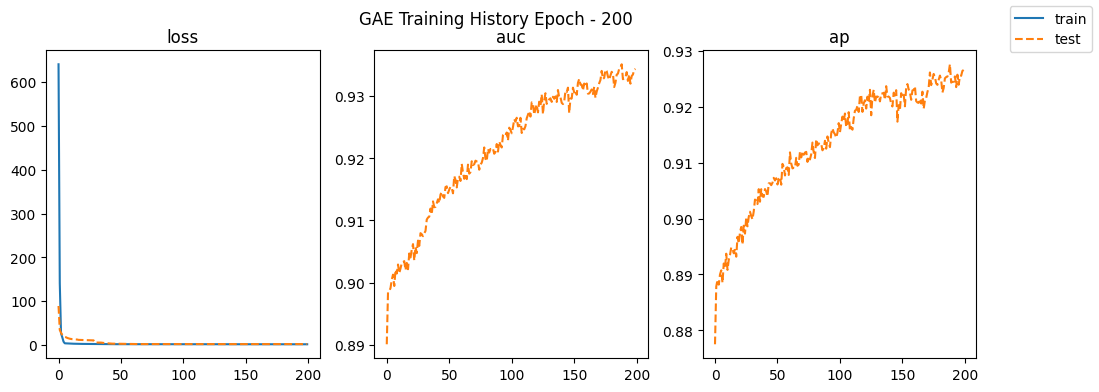

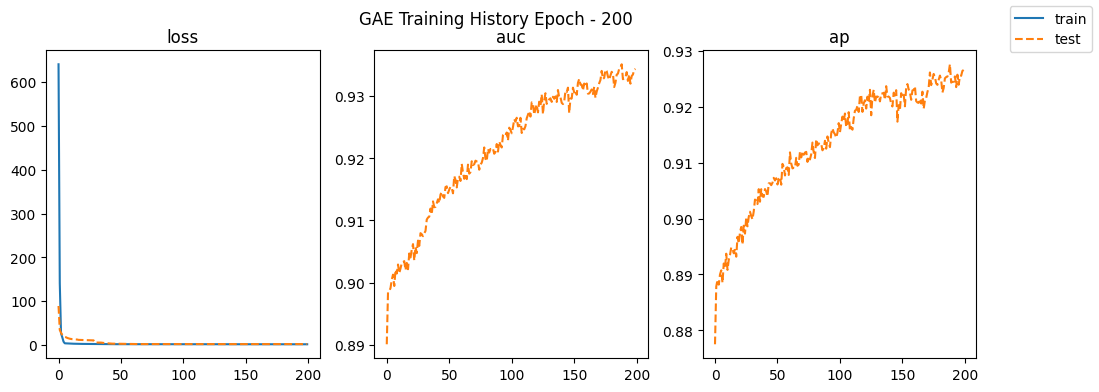

In [30]:
def get_file_path(n=None):
    return f"./save_results/gae_model {n}.pth"

# gae_model,node_model,optimizer,hist = load_model(get_file_path(200))
for i in range(6):
    train_gae(gae_model.double(),node_model.double(),optimizer,hist,50)
    save_model(gae_model,node_model,optimizer,hist,get_file_path(len(hist['train']['loss'])))

gae_model,node_model,optimizer,hist = load_model(get_file_path(200))
fig = plot_loss(hist)
savefig(fig,'GAE_training_hist')

In [31]:
from sklearn.metrics import average_precision_score, roc_auc_score
def test(self, z: Tensor, pos_edge_index: Tensor,
            neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
    
    pos_y = z.new_ones(pos_edge_index.size(1))
    neg_y = z.new_zeros(neg_edge_index.size(1))
    y = torch.cat([pos_y, neg_y], dim=0)

    pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
    neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
    pred = torch.cat([pos_pred, neg_pred], dim=0)
    y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()
    return roc_auc_score(y, pred), average_precision_score(y, pred)
data =train_data[0]
neg_edge = pyg_utils.negative_sampling(data.edge_index)
# y,pred = test(gae_model,gae_model.double().encode(data.x, data.edge_index),data.edge_index,neg_edge)
# roc_auc_score(y,pred)
data.edge_index.shape , test(gae_model,gae_model.double().encode(data.x, data.edge_index),data.edge_index,neg_edge).shape

(torch.Size([2, 9164]), torch.Size([9164]))

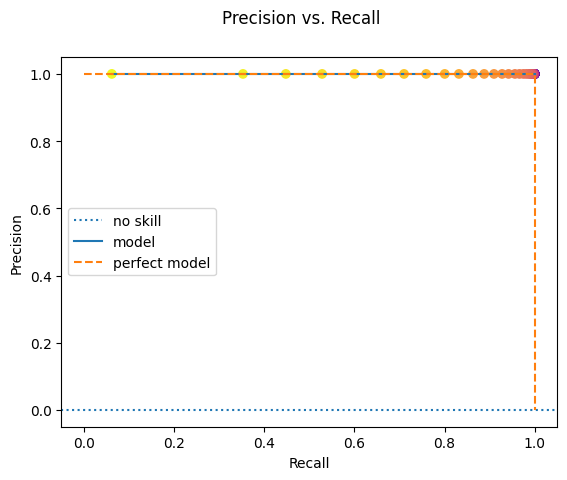

In [32]:
def calc_metric(model,data,threshold=None):
    model.eval()
    z = model.encode(data.x.float(), data.edge_index)
    edge_index = model.decoder(z, data.edge_index, sigmoid=True)
    edge_index = edge_index.long() if threshold is None else edge_index >= threshold
    edge_index = edge_index.detach().cpu()
    fn = lambda t : t.flatten().cpu().long()
    
    target = torch.ones(data.edge_index.size(1))
    cm = confusion_matrix(target,edge_index)

    return {
        "ideal_cm":confusion_matrix(target,edge_index),
        "cm": cm,
        "precision": precision_score(target,edge_index),
        "recall": recall_score(target,edge_index),
        "acc" : accuracy_score(target,edge_index),
        "f1": f1_score(target,edge_index)
    }
    
xs   = np.linspace(0,1.0)
recall_hist = []
precision_hist  = []
for x in xs:
    res = calc_metric(gae_model.float(),data,x)
    recall_hist.append(res['recall'])
    precision_hist.append(res['precision'])
    
    
fig,ax = plt.subplots(1,1)
fig.suptitle('Precision vs. Recall')
ax.scatter(recall_hist,precision_hist,c=xs,cmap='plasma')
ax.axhline(y=0,label='no skill',ls='dotted')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.plot(recall_hist,precision_hist,label='model')
ax.plot([0,1,1],[1,1,0], label='perfect model', ls='dashed')
ax.legend()

savefig(plt,'GAE_informed_precision_recall_thresholding')

In [33]:
def calc_model(model,data,threshold=None):
    model.eval()
    z = model.encode(data.x.float(), data.edge_index)
    adj = model.decoder.forward_all(z)
    adj = adj.long() if threshold is None else adj >= threshold
    edge_index = pyg_utils.dense_to_sparse(adj)[0]

    fn = lambda t : t.flatten().cpu().long()
    pred,target = fn(adj), fn(pyg_utils.to_dense_adj(data.edge_index))

    cm = confusion_matrix(target,pred)

    tn,fp = cm[0,:]
    fn,tp = cm[1,:]

    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    acc = (tn+tp) / sum([tn,fn, fp, tp])
    f1 = (precision * recall)/(precision + recall)

    return {
        "ideal_cm":confusion_matrix(target,target),
        "cm": cm,
        "size_ratio": edge_index.shape[1]/data.edge_index.shape[1],
        "precision": precision,
        "recall": recall,
        "acc" : acc,
        "f1": f1
    }

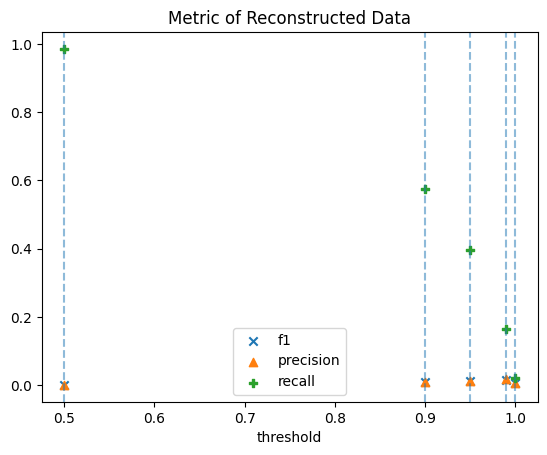

In [34]:
x = [0.5,0.9,0.95,0.99,0.9999]
y = []
precision_hist = []
recall_hist = []
size_hist = []
for t in x:
    res = calc_model(gae_model,test_data[0],t)
    precision_hist.append(res['precision'])
    recall_hist.append(res['recall'])
    size_hist.append(res['size_ratio'])
    y.append(res['f1'])

plt.title('Metric of Reconstructed Data')
[plt.axvline(1 if i is None else i,alpha=0.5,ls='--') for i in x]
plt.xlabel('threshold')
plt.scatter(x,y,label='f1',marker='x')
plt.scatter(x,precision_hist,label='precision',marker='^')
plt.scatter(x,recall_hist,label='recall',marker='P')
plt.legend()
savefig(plt,'GAE_thresholding_comp')

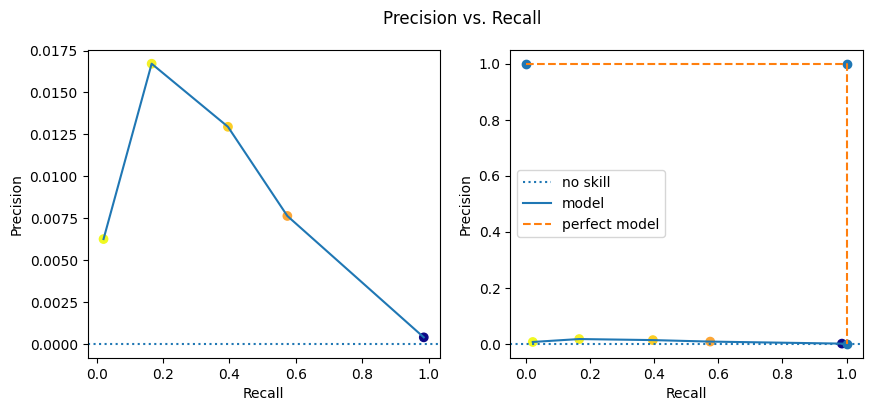

In [35]:
fig,axs = plt.subplots(1,2,figsize=(10,4))
fig.suptitle('Precision vs. Recall')
for ax in axs.flatten():
    ax.scatter(recall_hist,precision_hist,c=np.array(x),cmap='plasma')
    ax.axhline(y=0,label='no skill',ls='dotted')
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.plot(recall_hist,precision_hist,label='model')
    
axs[1].scatter([0,1,1],[1,0,1])
axs[1].plot([0,1,1],[1,1,0], label='perfect model', ls='dashed')
handles, labels = fig.axes[1].get_legend_handles_labels()
axs[1].legend(handles, labels)

savefig(plt,'GAE_precision_recall_thresholding')

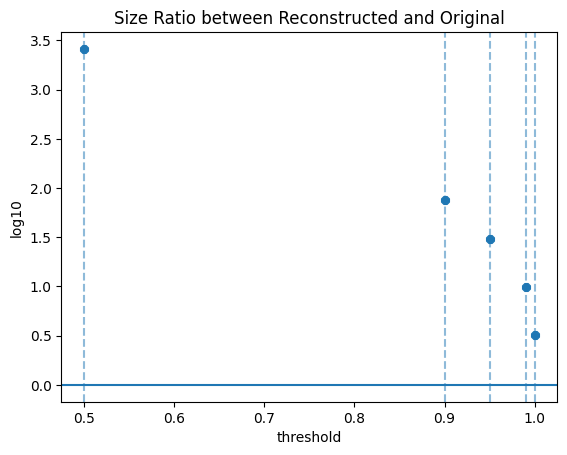

In [36]:
plt.title('Size Ratio between Reconstructed and Original')
plt.axhline(y=np.log10(1))
plt.ylabel('log10')
plt.xlabel('threshold')
[plt.axvline(1 if i is None else i,alpha=0.5,ls='--') for i in x]
plt.scatter(x,np.log10(size_hist),label='size_ratio',marker='8')
savefig(plt,'GAE_thresholding_size_comp')

# Model training

## GNNTrainer object

In [37]:
class GNN_trainer(object):
    def __init__(self, model):
        self.model = model
        self.metric_manager = metric_manager(modes=["train", "val"])

    def train_step(self, train_dataset, optimizer, criterion, args):
        train_targets = torch.tensor([])
        train_preds = torch.tensor([])
        test_targets = torch.tensor([])
        test_preds = torch.tensor([])
        train_losses = []
        test_losses = []

        for data in train_dataset:
            self.model.train()
            out = self.model(data)

            out = out.reshape(data.x.shape[0])

            ## Metric calculations
            # train data
            target_labels = data.y.detach().cpu()[data.train_idx]
            pred_scores = out.detach().cpu()[data.train_idx]
            train_targets = torch.cat((train_targets,target_labels))
            train_preds = torch.cat((train_preds,pred_scores))

            ## Training Step
            optimizer.zero_grad()
            loss = criterion(out[data.train_idx], data.y[data.train_idx])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            # validation data
            self.model.eval()
            target_labels = data.y.detach().cpu()[data.valid_idx]
            pred_scores = out.detach().cpu()[data.valid_idx]
            loss = criterion(out[data.valid_idx], data.y[data.valid_idx])
            test_targets = torch.cat((test_targets,target_labels))
            test_preds = torch.cat((test_preds,pred_scores))
            test_losses.append(loss.item())

        train_loss = sum(train_losses)/train_targets.size(0)
        test_loss = sum(test_losses)/test_targets.size(0)
        return train_preds, train_targets, test_preds, test_targets,train_loss,test_loss

    def train(self, train_dataset, optimizer, criterion, args):
        self.train_dataset = train_dataset
        for epoch in range(args['epochs']):
            fn = lambda: self.train_step(train_dataset, optimizer, criterion, args)
            train_preds, train_targets, test_preds,test_targets,train_loss,test_loss  = fn()

            self.metric_manager.store_metrics("train", train_preds, train_targets,train_loss)
            self.metric_manager.store_metrics("val", test_preds, test_targets,test_loss)

            if epoch%5 == 0:
                train_acc = self.metric_manager.output["train"]['accuracy'][-1]
                val_acc = self.metric_manager.output["val"]['accuracy'][-1]
                val_aucroc = self.metric_manager.output["val"]['aucroc'][-1]
                val_f1 = self.metric_manager.output["val"]['f1micro'][-1]
                print("epoch: {} - loss: {:.4f} - accuracy train: {:.4f} - accuracy valid: {:.4f}  - val roc: {:.4f}  - val f1micro: {:.4f}".format(epoch, train_loss, train_acc, val_acc, val_aucroc,val_f1))

    # To predict labels
    def predict(self, data=None, unclassified_only=True, threshold=0.5):
        self.model.eval()

        out = self.model(data)
        out = out.reshape((data.x.shape[0]))

        if unclassified_only:
            pred_scores = out.detach().cpu().numpy()[data.test_idx]
        else:
            pred_scores = out.detach().cpu().numpy()

        pred_labels = pred_scores > threshold

        return {"pred_scores":pred_scores, "pred_labels":pred_labels}

    # To save metrics
    def save_metrics(self, save_name, path="./save/"):
        file_to_store = open(path + save_name, "wb")
        pickle.dump(self.metric_manager, file_to_store)
        file_to_store.close()

    # To save model
    def save_model(self, save_name, path="./save/"):
        torch.save(self.model.state_dict(), path + save_name)

## Training and validation

In [38]:
args={"epochs":25,
      'lr':0.01,
      'weight_decay':1e-5,
      'heads':2,
      'hidden_dim': 32,
      'dropout': 0.5
      }

## Train Classifier

In [42]:
THRESHOLD = 0.99
recon_data = [reconstruct_data(gae_model.double(),node_model.double(),data,threshold=THRESHOLD) for data in train_data]
recon_data = [data.to(device) for data in recon_data]

In [43]:
def test(model,dataset):
    gnn_trainer = GNN_trainer(model)
    test_metric_manager = metric_manager(['val'])

    for data in dataset:

        idx = data.classified_idx
        y = data.y[idx].cpu()
        res = gnn_trainer.predict(data,False)

        pred = res['pred_labels'][idx]
        pred = torch.tensor(pred)

        test_metric_manager.store_metrics('val',pred,y,0)

    return test_metric_manager

def train(model,train_data,name):
    # Push data to GPU

    # Setup training settings
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    criterion = torch.nn.BCELoss()

    # Train
    gnn_trainer = GNN_trainer(model)

    gnn_trainer.train(train_data, optimizer, criterion, args)
    mm = test(model,test_data)
    file_to_store = open(FOLDERNAME + f"/save_results/{name}_future.results", "wb")
    pickle.dump(mm, file_to_store)
    file_to_store.close()

    gnn_trainer.save_metrics(f"{name}.results", path=FOLDERNAME + "/save_results/")
    gnn_trainer.save_model(f"{name}.pth", path=FOLDERNAME + "/save_results/")

    return gnn_trainer

In [44]:
model = GCN(42)
print("Prebuilt GCN from PyG")
gnn_trainer = train(model.double().to(device),train_data+train_data,"GCN")


model = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GAT from PyG")
gnn_trainer = train(model.double().to(device),train_data+train_data,"GAT")


model = GATv2(train_data[0].num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GATv2 from PyG")
train(model.double().to(device),train_data+train_data,"GATv2")

Prebuilt GCN from PyG
epoch: 0 - loss: 0.0006 - accuracy train: 0.8403 - accuracy valid: 0.8388  - val roc: 0.6531  - val f1micro: 0.8388
epoch: 5 - loss: 0.0002 - accuracy train: 0.9326 - accuracy valid: 0.9236  - val roc: 0.9138  - val f1micro: 0.9236
epoch: 10 - loss: 0.0002 - accuracy train: 0.9635 - accuracy valid: 0.9527  - val roc: 0.9324  - val f1micro: 0.9527
epoch: 15 - loss: 0.0002 - accuracy train: 0.9619 - accuracy valid: 0.9439  - val roc: 0.9213  - val f1micro: 0.9439
epoch: 20 - loss: 0.0001 - accuracy train: 0.9770 - accuracy valid: 0.9563  - val roc: 0.9475  - val f1micro: 0.9563
Prebuilt GAT from PyG
epoch: 0 - loss: 0.0005 - accuracy train: 0.8659 - accuracy valid: 0.8653  - val roc: 0.8081  - val f1micro: 0.8653
epoch: 5 - loss: 0.0002 - accuracy train: 0.9513 - accuracy valid: 0.9493  - val roc: 0.9662  - val f1micro: 0.9493
epoch: 10 - loss: 0.0002 - accuracy train: 0.9644 - accuracy valid: 0.9584  - val roc: 0.9744  - val f1micro: 0.9584
epoch: 15 - loss: 0.0001

In [45]:
model = GCN(42)
print("Prebuilt GCN from PyG")
gnn_trainer = train(model.double().to(device),recon_data+recon_data,"GCN_recon")


model = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GAT from PyG")
gnn_trainer = train(model.double().to(device),recon_data+recon_data,"GAT_recon")


model = GATv2(train_data[0].num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GATv2 from PyG")
train(model.double().to(device),recon_data+recon_data,"GATv2_recon")

Prebuilt GCN from PyG
epoch: 0 - loss: 0.0006 - accuracy train: 0.8505 - accuracy valid: 0.8497  - val roc: 0.4894  - val f1micro: 0.8497
epoch: 5 - loss: 0.0003 - accuracy train: 0.9357 - accuracy valid: 0.9366  - val roc: 0.8211  - val f1micro: 0.9366
epoch: 10 - loss: 0.0003 - accuracy train: 0.9395 - accuracy valid: 0.9397  - val roc: 0.8243  - val f1micro: 0.9397
epoch: 15 - loss: 0.0002 - accuracy train: 0.9403 - accuracy valid: 0.9368  - val roc: 0.9419  - val f1micro: 0.9368
epoch: 20 - loss: 0.0002 - accuracy train: 0.9451 - accuracy valid: 0.9419  - val roc: 0.9491  - val f1micro: 0.9419
Prebuilt GAT from PyG


OutOfMemoryError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 3.00 GiB total capacity; 2.30 GiB already allocated; 0 bytes free; 2.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model = GCN(42)
print("Prebuilt GCN from PyG")
gnn_trainer = train(model.double().to(device),recon_data+train_data,"GCN_mix")


model = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GAT from PyG")
gnn_trainer = train(model.double().to(device),recon_data+train_data,"GAT_mix")


model = GATv2(train_data[0].num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GATv2 from PyG")
train(model.double().to(device),recon_data+train_data,"GATv2_mix")

: 

In [ ]:
def zip_result():
    if is_colab():
        !zip -r '/content/drive/MyDrive/data science project/save_results' save_results
    else:
        !zip -r save_results.zip save_results
zip_result()

: 

You can also run our custom models GATmodif and GATv2modif by setting in args, prebuild=False or run with GATmodif_3layer: \\
```model = GATmodif_3layer(data_train.num_node_features, args['hidden_dim'], 1, args) ``` \\
After training few models, you can load your saved outputs. Here we load the outputs of GAT and GATv2 from builtin PyG.

In [ ]:
# Fetch results from saved
fn="GAT.results"
metric_manager_GAT = pickle.load(open(f"{FOLDERNAME}/save_results/{fn}", "rb"))
metric_manager_GAT.get_best("aucroc")

: 

# Performance visualization
Then we can compare the performance of our models by plotting the results with a selected metric.


## Training Cross Comparisons 1

In [ ]:
def plot_training_comp(metric_manager_list, names, metrics=("aucroc",),version=('val','train'),title="Training History"):
    # from itertools import cycle
    # linestyles = cycle(['solid'])
    fig,axs = plt.subplots(len(metrics),1,figsize=(6,len(metrics)*2))
    axs = axs.flatten() if len(metrics) > 1 else [axs]
    linestyles = ['solid', 'dashed', 'dotted']
    for ax,metric in zip(axs,metrics):
        for name,metric_manager in zip(names,metric_manager_list):
            ax.set_title(title)
            for v,ls in zip(version,linestyles):
                y = metric_manager.output[v][metric]
                epochs = np.arange(len(y))
                ax.plot(epochs,y,label=f'{v} {name}',ls=ls)

            # ax.legend()
            ax.set_xlabel('epoch')
            ax.set_ylabel(metric)
    handles, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.show()
    return fig,axs

def plot_timestep_comp(metric_manager_list, names, metrics=("aucroc",), version="val",title="Val set comparison",xlabel='timesteps'):
    # from itertools import cycle
    # linestyles = cycle(['solid'])
    fig,axs = plt.subplots(len(metrics),1,figsize=(6,len(metrics)*2))
    plt.subplots_adjust(hspace=0.6)
    axs = axs.flatten() if len(metrics) > 1 else [axs]
    linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
    fig.suptitle(title)
    for ax,metric in zip(axs,metrics):
        for name,metric_manager,ls in zip(names,metric_manager_list,linestyles):
            # ax.set_title(title)
            y = metric_manager.output[version][metric]
            epochs = np.arange(len(y))
            ax.plot(epochs,y,label=name,ls=ls)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(metric)

    handles, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.show()
    return fig,axs

# Load saved outputs
def load_results(fn):
    mm1 = pickle.load(open(FOLDERNAME + "save_results/" + fn, "rb"))
    return mm1

def load_model_state_dict(name):
    return torch.load(FOLDERNAME + f'save_results/{name}.pth')

: 

In [ ]:
metric_managers = []
names = ['GAT','GAT_mix','GAT_recon']

for name in names:
    model = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args)
    model = model.to(device)
    model.load_state_dict(load_model_state_dict(name))
    gnn = test(model.double(),train_data + test_data)
    metric_managers.append(gnn)

fig,axs = plot_timestep_comp(metric_managers,
                             names,
                             ["accuracy","f1micro","aucroc","recall","precision"],
                             title='GAT trained with different dataset',
                             xlabel='timesteps')
for ax in axs.flatten():
    ax.axvline(x=len(train_data)-1,color='black', linestyle='dotted', alpha=0.5)

savefig(fig,'GAT_different_dataset_comp')

: 

In [ ]:
metric_managers = []
names = ['GATv2','GATv2_mix','GATv2_recon']

for name in names:
    model = GATv2(train_data[0].num_node_features, args['hidden_dim'], 1, args)
    model = model.to(device)
    model.load_state_dict(load_model_state_dict(name))
    gnn = test(model.double(),train_data + test_data)
    metric_managers.append(gnn)

fig,axs = plot_timestep_comp(metric_managers,
                             names,
                             ["accuracy","f1micro","aucroc","recall","precision"],
                             title='GATv2 trained with different dataset',
                             xlabel='timesteps')
for ax in axs.flatten():
    ax.axvline(x=len(train_data)-1,color='black', linestyle='dotted', alpha=0.5)

savefig(fig,'GATv2_different_dataset_comp')

: 

In [ ]:
metric_managers = []
names = ['GCN','GCN_mix','GCN_recon']

for name in names:
    model = GCN(42).to(device)
    model.load_state_dict(load_model_state_dict(name))
    gnn = test(model.double(),train_data+test_data)
    metric_managers.append(gnn)

fig,axs = plot_timestep_comp(metric_managers,
                   names,
                   ["accuracy","f1micro","aucroc","recall","precision"],
                   title='CGN trained with different dataset',
                   xlabel='timesteps')

for ax in axs.flatten():
    ax.axvline(x=len(train_data)-1,color='black', linestyle='dotted', alpha=0.5)

savefig(fig,'GCN_different_dataset_comp')

: 

In [ ]:
model_ctor = [GCN(42),
              GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args),
              GATv2(train_data[0].num_node_features, args['hidden_dim'], 1, args)]
metric_managers = []
names = ['GCN','GAT','GATv2']

for model,name in zip(model_ctor,names):
    model.to(device)
    model.load_state_dict(load_model_state_dict(name))
    gnn = test(model.double(),train_data+test_data)
    metric_managers.append(gnn)

fig,axs = plot_timestep_comp(metric_managers,
                   names,
                   ["accuracy","aucroc","f1micro","recall","precision"],
                   xlabel='timesteps',
                   title='Different Model Comparison')

for ax in axs.flatten():
    ax.axvline(x=len(train_data)-1,color='black', linestyle='dotted', alpha=0.5)

savefig(fig,'model_comp_1')

: 

In [ ]:
model = GCN(42).to(device)
model.load_state_dict(load_model_state_dict('GCN'))

model_2 = GCN(42).to(device)
model_2.load_state_dict(load_model_state_dict('GCN_recon'))

metric_managers = [test(model.double(),train_data),
                   test(model_2.double(),train_data)]

names = ['GCN','GCN_recon']

mean = lambda t: torch.tensor(t).mean().round(decimals=4).item()

output1 = metric_managers[0].output['val']
output2 = metric_managers[1].output['val']

metrics = "f1micro accuracy recall precision".split()

# plot_timestep_comp(metric_managers,
#                    names,
#                    ["accuracy","f1micro","aucroc","recall","precision"],
#                    xlabel='timesteps')
f = lambda m : (mean(output1[m]), mean(output2[m]))
{
    # 'f1micro': (mean(output1['f1micro']), mean(output2['f1micro'])),
    m:f(m) for m in metrics
}

: 

## Graph visualization
Now after training previous models, we can also visualize our predicted labels nodes as licit or illicit.We are going to show the graph for one time period.

In [ ]:
def plot_graph(data,output,time_period=None,directed=False):
    id_to_node = data.id_to_node
    edge_index = data.edge_index.cpu().numpy().T

    node_color = []
    for node_id in id_to_node.keys():
        if node_id in data.classified_illicit_idx:
            label = "red" # fraud
        elif node_id in data.classified_licit_idx:
            label = "green" # fraud
        elif output['pred_labels'][node_id]:
            label = "orange" # Predicted fraud
        else:
            label = "blue" # Not fraud predicted
        node_color.append(label)

    # Setup networkx graph
    if directed is True:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    G.add_edges_from(edge_index)

    # Plot the graph
    plt.figure(3,figsize=(16,16))
    plt.title("Time period:"+str(time_period))

    # spring layout
    nx.draw_networkx(G, node_color=node_color, node_size=20,
                     with_labels=False,arrowsize=5)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red','green','orange','blue']]
    plt.legend(legend_elements, ['illicit','licit','predicted illicit','predicted licit'])

# Load one model
model = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args).to(device).double()
model.load_state_dict(torch.load(FOLDERNAME + "/save_results/" + "GATprebuilt.pth"))
gnn = GNN_trainer(model)
output = gnn.predict(data=train_data[0], unclassified_only=False)

time_period = 12
data = train_data[time_period]
output = gnn.predict(data=data, unclassified_only=False)

id_to_node = train_data[time_period].id_to_node
edge_index = train_data[time_period].edge_index.cpu().numpy().T

plot_graph(data,output,time_period)
savefig(plt,f'full_transaction_graph_{time_period}')

: 

## Training Cross comparisons 2

In [ ]:
name = "GCN"
names = [name]
model_name_list = [f'{name}.results' for name in names]

metric_managers = [load_results(fn) for fn in model_name_list]
fig,axs = plot_training_comp(metric_managers, names, ["aucroc",])
savefig(fig,'GCN_train_hist')

: 

In [ ]:
name = "GCN_mix"
names = [name]
model_name_list = [f'{name}.results' for name in names]

metric_managers = [load_results(fn) for fn in model_name_list]
fig,axs = plot_training_comp(metric_managers, names, ["aucroc",])
savefig(fig,'GCN_mix_train_hist')

: 

In [ ]:
# Take names of the saved files
model_name_list = ["GCN.results","GAT.results","GATv2.results"]
#Assign names to plots
names = ["GCN","GAT","GATv2",]

#Iterate to load saved outputs and plots
metric_managers = [load_results(fn) for fn in model_name_list]
fig,axs = plot_timestep_comp(metric_managers, names, ["aucroc","loss"],xlabel='Epochs')
savefig(fig,'model_hist_comp_2')

: 

In [ ]:
#Assign names to plots
names = ['GAT','GATv2','GCN',]

model_ctor = [GCN(42),
              GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args),
              GATv2(train_data[0].num_node_features, args['hidden_dim'], 1, args)]
metric_managers = []
names = ['GCN','GAT','GATv2']

for model,name in zip(model_ctor,names):
    model.to(device)
    model.load_state_dict(load_model_state_dict(name))
    gnn = test(model.double(),train_data+test_data)
    metric_managers.append(gnn)

fig,axs = plot_timestep_comp(metric_managers, names, ["aucroc"],title="aucroc comparison")

for ax in axs:
    ax.axvline(x=len(train_data)-1,color='black', linestyle='dotted', alpha=0.5)
savefig(fig,'model_comp_2')

: 

## Best metrics

Next, we show you the best results of each model into a table.

In [ ]:
# Take names of the saved files
model_name_list = ["GATv2.results", "GCN.results","GAT.results",
                   "GATv2_mix.results", "GCN_mix.results","GAT_mix.results",
                   "GATv2_recon.results", "GCN_recon.results","GAT_recon.results",]
#Assign names to plots
names = ['GAT','GAT_mix','GAT_recon','GATv2','GATv2_mix','GATv2_recon','GCN','GCN_mix','GCN_recon',]

#Iterate to load saved outputs and plots
mm_list0 = [load_results(fn) for fn in model_name_list]

# Plot best results of each into a table
d = {"model_versions":[],
     "aucroc": [],
     "accuracy": [],
     "f1micro": [],
     "f1macro": []}
for c1, mm in enumerate(mm_list0):
    d["model_versions"].append(names[c1])
    best = mm.get_best("aucroc")
    d["aucroc"].append(best["aucroc"])
    d["accuracy"].append(best["accuracy"])
    d["f1micro"].append(best["f1micro"])
    d["f1macro"].append(best["f1macro"])

df = pd.DataFrame(data=d)
df.round(3).sort_values('aucroc',ascending=False).reset_index(drop=True)

: 